# Gene-Peak Clusters

**Created**: 19 January 2022

## Environment

In [24]:
if (!requireNamespace("rtracklayer", quietly=T)) {
    install.packages("rtracklayer")
}

if (!requireNamespace("ComplexHeatmap", quietly=TRUE)) {
    BiocManager::install("ComplexHeatmap")
}

In [25]:
library(tidyverse)
library(RColorBrewer)
library(data.table)
library(rtracklayer)
library(ComplexHeatmap)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

## Load Data

In [27]:
peaks <- fread("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/peak_counts.tsv", sep="\t")

In [28]:
head(peaks)

GeneID,Chr,Start,End,Strand,SRR7650746.filtered.bam,SRR7650847.filtered.bam,SRR7650752.filtered.bam,SRR7650828.filtered.bam,SRR7650841.filtered.bam,⋯,SRR7650809.filtered.bam,SRR7650846.filtered.bam,SRR7650844.filtered.bam,SRR7650801.filtered.bam,SRR7650843.filtered.bam,SRR7650849.filtered.bam,SRR7650811.filtered.bam,SRR7650826.filtered.bam,SRR7650831.filtered.bam,SRR7650770.filtered.bam
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1:23224-23849,1,23224,23849,+,13,6,29,8,6,⋯,30,6,3,10,4,13,6,4,10,10
1:24025-26778,1,24025,26778,+,55,32,66,52,32,⋯,76,47,30,80,36,41,76,53,68,45
1:28524-30136,1,28524,30136,+,615,232,869,323,288,⋯,99,132,300,530,284,64,425,335,320,307
1:30354-30875,1,30354,30875,+,13,4,14,11,3,⋯,12,3,0,12,2,3,8,8,5,10
1:31109-31894,1,31109,31894,+,16,16,48,17,3,⋯,16,10,4,24,4,11,27,11,17,18
1:32151-32330,1,32151,32330,+,3,4,7,5,2,⋯,6,2,0,3,2,2,1,5,8,6


In [5]:
id.split.1 <- do.call(rbind, strsplit(rownames(peaks), ":"))
id.split.2 <- do.call(rbind, strsplit(id.split.1[,2], "-"))

peaks.info <- as.data.frame(cbind(rownames(peaks), id.split.1[,1], id.split.2))
colnames(peaks.info) <- c("Peak.ID", "Peak.Chr", "Peak.Start", "Peak.End")

head(peaks.info)

,Peak.ID,Peak.Chr,Peak.Start,Peak.End
,<chr>,<chr>,<chr>,<chr>
1,1:24025-26778,1,24025,26778
2,1:28524-30136,1,28524,30136
3,1:39133-40497,1,39133,40497
4,1:131043-132635,1,131043,132635
5,1:132691-134636,1,132691,134636
6,1:194914-197668,1,194914,197668


In [6]:
atac.seq.metadata <- read.csv("03_Functional_Interpretation/metadata/reads_calderon_et_al_atac_seq.txt")

In [7]:
head(atac.seq.metadata)

,Run,Assay.Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Cell_type,Center.Name,Consent,⋯,LibrarySelection,LibrarySource,lineage,Organism,Platform,ReleaseDate,Sample.Name,source_name,SRA.Study,Treatment
,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SRR7650729,ATAC-seq,130,7671684082,PRJNA484801,SAMN09769836,3235449960,Bulk_B,GEO,public,⋯,other,GENOMIC,B,Homo sapiens,ILLUMINA,2018-09-06T00:00:00Z,GSM3320229,primary blood,SRP156496,no_treament
2,SRR7650730,ATAC-seq,130,8755083677,PRJNA484801,SAMN09769835,3691300841,Bulk_B,GEO,public,⋯,other,GENOMIC,B,Homo sapiens,ILLUMINA,2018-09-06T00:00:00Z,GSM3320230,primary blood,SRP156496,treatment1
3,SRR7650731,ATAC-seq,131,8483939942,PRJNA484801,SAMN09769834,3602660374,Mem_B,GEO,public,⋯,other,GENOMIC,B,Homo sapiens,ILLUMINA,2018-09-06T00:00:00Z,GSM3320231,primary blood,SRP156496,no_treament
4,SRR7650732,ATAC-seq,131,7895482240,PRJNA484801,SAMN09769833,3334427072,Mem_B,GEO,public,⋯,other,GENOMIC,B,Homo sapiens,ILLUMINA,2018-09-06T00:00:00Z,GSM3320232,primary blood,SRP156496,treatment1
5,SRR7650733,ATAC-seq,132,7063118195,PRJNA484801,SAMN09769832,3012041722,Naive_B,GEO,public,⋯,other,GENOMIC,B,Homo sapiens,ILLUMINA,2018-09-06T00:00:00Z,GSM3320233,primary blood,SRP156496,no_treament
6,SRR7650734,ATAC-seq,131,9335521479,PRJNA484801,SAMN09769831,3972942953,Naive_B,GEO,public,⋯,other,GENOMIC,B,Homo sapiens,ILLUMINA,2018-09-06T00:00:00Z,GSM3320234,primary blood,SRP156496,treatment1


In [8]:
genes <- read.csv("~/gains_team282/epigenetics/calderon_et_al/analysis/rna_seq/counts_normalized.csv", row.names=1, stringsAsFactors=F)

In [9]:
head(genes)

,SRR11007187,SRR11007186,SRR7647733,SRR11007183,SRR11007177,SRR11007062,SRR7647801,SRR7647731,SRR11007089,SRR11007061,⋯,SRR11007105,SRR11007169,SRR11007182,SRR7647655,SRR11007094,SRR7647697,SRR11007106,SRR7647660,SRR7647768,SRR11007097
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000223972,-4.373643,-4.9524289,-4.698456,-5.8748841,-5.689776,-7.221049,-4.344822,-3.579351,-6.719863,-6.040948,⋯,-6.093293,-5.567996,-5.0025744,-5.928265,-2.870949,-5.265528,-5.834175,-3.114331,-4.171178,-3.837762
ENSG00000227232,-4.597347,-0.7838148,-3.808940,-0.2159444,-5.913479,-3.861321,-3.702782,-2.689835,-4.424265,-3.504342,⋯,-2.915984,-3.469771,0.1999871,-2.337211,-2.318576,-1.701197,-1.602419,-1.956236,-2.809919,-4.360893
ENSG00000240361,-4.115854,-4.6946401,-4.684772,-5.6170953,-5.431987,-4.225502,-4.374263,-1.980705,-6.531671,-5.852756,⋯,-5.897970,-5.310207,-4.7447855,-5.740073,-2.320187,-5.070206,-5.638853,-2.926139,-3.913390,-3.642439
ENSG00000238009,-4.471617,-5.0504023,-4.815500,-4.3878950,-5.787749,-7.659453,-3.848383,-3.696395,-7.158266,-6.479352,⋯,-2.903252,-5.665969,-5.1005477,-4.781706,-1.724390,-2.923484,-5.814059,-3.552734,-4.269152,-3.817646
ENSG00000233750,-4.311496,-4.8902815,-4.867449,-5.8127367,-5.627628,-7.442411,-2.275005,-3.748344,-6.941225,-6.262310,⋯,-3.733449,-5.505848,-4.9404269,-4.564664,-3.577738,-5.227613,-5.796260,-3.335693,-4.109031,-3.799846
ENSG00000268903,-4.708663,-5.2874484,-4.940078,-6.2099036,-6.024795,-5.727305,-1.905618,-1.013619,-5.226119,-1.288470,⋯,-6.261876,-5.903015,-5.3375938,-4.071951,-2.904452,-5.434112,-6.002759,-4.427942,-4.506198,-4.006345


In [10]:
genes.info <- import("/lustre/scratch118/humgen/resources/rna_seq_genomes/Homo_sapiens.GRCh38.99.gtf")

In [11]:
genes.info <- as.data.frame(genes.info) %>%
    dplyr::filter(gene_id %in% rownames(genes)) %>%
    dplyr::filter(type == "gene") %>%
    dplyr::select(Gene.ID=gene_id, Chr=seqnames, Start=start, End=end, Width=width, Strand=strand, Gene.Name=gene_name, Gene.Biotype=gene_biotype)

head(genes.info)

,Gene.ID,Chr,Start,End,Width,Strand,Gene.Name,Gene.Biotype
,<chr>,<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
1,ENSG00000223972,1,11869,14409,2541,+,DDX11L1,transcribed_unprocessed_pseudogene
2,ENSG00000227232,1,14404,29570,15167,-,WASH7P,unprocessed_pseudogene
3,ENSG00000240361,1,57598,64116,6519,+,OR4G11P,transcribed_unprocessed_pseudogene
4,ENSG00000238009,1,89295,133723,44429,-,AL627309.1,lncRNA
5,ENSG00000233750,1,131025,134836,3812,+,CICP27,processed_pseudogene
6,ENSG00000268903,1,135141,135895,755,-,AL627309.6,processed_pseudogene


In [12]:
rna.seq.metadata <- read.csv("03_Functional_Interpretation/metadata/reads_calderon_et_al_rna_seq.txt")

In [13]:
head(rna.seq.metadata)

,Run,Assay.Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_type,Center.Name,Consent,⋯,LibrarySelection,LibrarySource,lineage,Organism,Platform,ReleaseDate,Sample.Name,source_name,SRA.Study,Treatment
,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SRR11007061,RNA-Seq,192,8160479782,PRJNA484735,SAMN09768434,2579781267,CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319750,primary blood,SRP156452,no_treament
2,SRR11007062,RNA-Seq,195,15315982752,PRJNA484735,SAMN09768433,4836924733,CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319751,primary blood,SRP156452,treatment1
3,SRR11007063,RNA-Seq,195,13128598440,PRJNA484735,SAMN09768432,4155236675,Central_memory_CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319752,primary blood,SRP156452,no_treament
4,SRR11007064,RNA-Seq,193,4866405615,PRJNA484735,SAMN09768431,1546902050,Central_memory_CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319753,primary blood,SRP156452,treatment1
5,SRR11007065,RNA-Seq,195,9601276948,PRJNA484735,SAMN09768430,3023735003,Effector_memory_CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319754,primary blood,SRP156452,no_treament
6,SRR11007066,RNA-Seq,196,9273440229,PRJNA484735,SAMN09768429,2953466798,Effector_memory_CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319755,primary blood,SRP156452,treatment1


## Find Overlapping Samples

A sample is uniquely identified given the donor, cell type, and treatment. I will use this to map runs between the two data modalities.

In [14]:
sample.map <- merge(
    atac.seq.metadata %>%
        dplyr::mutate(Treatment=plyr::revalue(Treatment, c("no_treament"="No_Treatment", "treatment1"="Treatment_1", "treatment2"="Treatment_2"))) %>%
        dplyr::mutate(ID=paste0(Donor, ":", Cell_type, ":", Treatment)) %>%
        dplyr::select(ID, ATAC.Seq.ID=Run),
    rna.seq.metadata %>%
        dplyr::mutate(Treatment=plyr::revalue(Treatment, c("no_treament"="No_Treatment", "treatment1"="Treatment_1", "treatment2"="Treatment_2"))) %>%
        dplyr::mutate(ID=paste0(donor, ":", cell_type, ":", Treatment)) %>%
        dplyr::select(ID, RNA.Seq.ID=Run),
    by="ID"
) %>%
    dplyr::filter(ATAC.Seq.ID %in% colnames(peaks)) %>%
    dplyr::filter(RNA.Seq.ID %in% colnames(genes))

Reorder peak counts and gene counts by sample map so that the matrices are directly comparable.

In [15]:
head(sample.map)

,ID,ATAC.Seq.ID,RNA.Seq.ID
,<chr>,<chr>,<chr>
1,1001:Bulk_B:No_Treatment,SRR7650729,SRR7647654
2,1001:Bulk_B:Treatment_1,SRR7650730,SRR7647655
3,1001:CD8pos_T:No_Treatment,SRR7650736,SRR11007061
4,1001:CD8pos_T:Treatment_1,SRR7650737,SRR11007062
5,1001:Central_memory_CD8pos_T:No_Treatment,SRR7650738,SRR11007063
6,1001:Central_memory_CD8pos_T:Treatment_1,SRR7650739,SRR11007064


In [16]:
peaks <- peaks[, sample.map$ATAC.Seq.ID]
colnames(peaks) <- sample.map$ID

In [17]:
genes <- genes[, sample.map$RNA.Seq.ID]
colnames(genes) <- sample.map$ID

## Peaks near Gene TSS

We define the *cis* region to be the 1 Mb region flanking the transcription start site (TSS) of a gene. I will identify peaks that are in the 1 Mb region around each gene.

In [18]:
peaks.ranges <- peaks.info %>%
    dplyr::filter(Peak.Chr %in% genes.info$Chr) %>%
    makeGRangesFromDataFrame(
        df=.,
        seqnames.field="Peak.Chr",
        start.field="Peak.Start",
        end.field="Peak.End",
        keep.extra.columns=TRUE
    )

In [19]:
cis.ranges <- genes.info %>%
    dplyr::filter(Chr %in% peaks.info$Peak.Chr) %>%
    dplyr::mutate(TSS=ifelse(Strand == "+", Start, End)) %>%
    dplyr::mutate(Cis.Start=TSS - (10^6 - 1)) %>%
    dplyr::mutate(Cis.Start=ifelse(Cis.Start < 1, 1, Cis.Start)) %>%
    dplyr::mutate(Cis.End=TSS + (10^6)) %>%
    dplyr::mutate(Cis.End=ifelse(Cis.End < 1, 1, Cis.End)) %>%
    makeGRangesFromDataFrame(
        df=.,
        seqnames.field="Chr",
        start.field="Cis.Start",
        end.field="Cis.End",
        keep.extra.columns=TRUE
    )

In [20]:
cis.eqtl <- readRDS("~/gains_team282/eqtl/cisresults/cisqtl_all_significant.rds")

In [21]:
gene.idx <- which(cis.ranges$Gene.Name == "AGPAT4")
gene.id <- mcols(cis.ranges[gene.idx,])[,"Gene.ID"]

In [22]:
overlaps <- findOverlaps(cis.ranges, peaks.ranges) %>%
    as.data.frame() %>%
    dplyr::filter(queryHits == gene.idx)

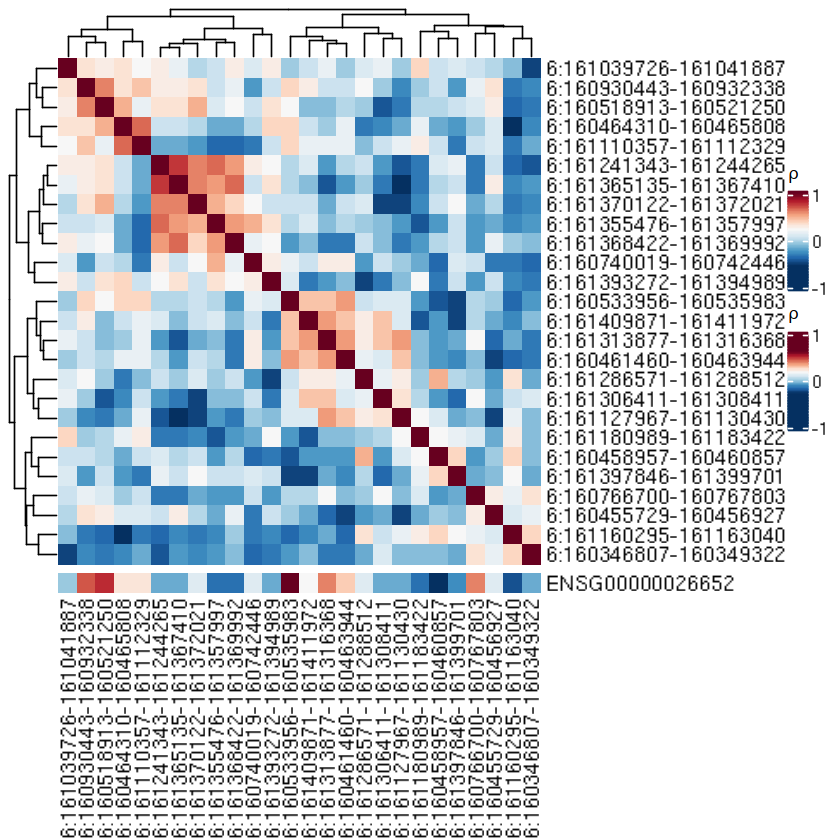

In [23]:
peak.ids <- mcols(peaks.ranges[overlaps$subjectHits,])[,"Peak.ID"]

cor.mtx.all <- cor(t(rbind(
    peaks[peak.ids, sample.map$ID[grepl("Monocyte", sample.map$ID)]],
    genes[gene.idx, sample.map$ID[grepl("Monocyte", sample.map$ID)]]
)), method="kendall")

cor.mtx <- cor.mtx.all[peak.ids, peak.ids]

cor.mtx.gene <- cor.mtx.all[gene.id, peak.ids, drop=F]

colors <- colorRampPalette(rev(brewer.pal(11, "RdBu")))(101)
h1 <- Heatmap(cor.mtx, col=colors, heatmap_legend_param=list(
    title=bquote(rho), at=c(-1, 0, 1)
))
h2 <- Heatmap(cor.mtx.gene, col=colors, heatmap_legend_param=list(
    title=bquote(rho), at=c(-1, 0, 1)
))
h1 %v% h2

In [105]:
cis.eqtl %>%
    dplyr::filter(chr==14) %>%
    dplyr::filter(SNPpos >= 22847665) %>%
    dplyr::filter(SNPpos <= 22850275)

snps,gene,statistic,pvalue,beta,se,chr,SNPpos,TSS,threshold
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>


In [88]:
da.peaks <- read.csv("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/da_peak_set.csv", row.names=1)

In [60]:
da.peaks %>%
    dplyr::filter(Cell.Type=="Monocytes") %>%
    dplyr::arrange(desc(abs(logFC)))

Contrast,Cell.Type,Peak.ID,Peak.Chr,Peak.Start,Peak.End,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Monocytes_Stimulated-Monocytes_Baseline,Monocytes,14:22850378-22852159,14,22850378,22852159,2.245294,1.8136113,6.872552,1.886279e-10,7.002811e-06,12.225601
Monocytes_Stimulated-Monocytes_Baseline,Monocytes,12:24718000-24720180,12,24718000,24720180,2.213399,2.0312811,5.347850,3.517275e-07,2.176314e-03,5.837434
Monocytes_Stimulated-Monocytes_Baseline,Monocytes,6:161127967-161130430,6,161127967,161130430,1.793257,2.2065711,5.258303,5.293406e-07,2.456471e-03,5.490682
Monocytes_Stimulated-Monocytes_Baseline,Monocytes,2:224909644-224910820,2,224909644,224910820,-1.704316,0.8492639,-5.667854,7.894515e-08,7.327097e-04,7.105455
Monocytes_Stimulated-Monocytes_Baseline,Monocytes,4:102257459-102259450,4,102257459,102259450,1.620826,1.5655494,4.888759,2.732540e-06,5.838769e-03,4.099729
Monocytes_Stimulated-Monocytes_Baseline,Monocytes,5:172756712-172758992,5,172756712,172758992,1.602480,2.2825984,4.911548,2.474905e-06,5.838769e-03,4.183570
Monocytes_Stimulated-Monocytes_Baseline,Monocytes,14:22847665-22850275,14,22847665,22850275,1.560427,2.2247934,4.884901,2.778667e-06,5.838769e-03,4.085557
Monocytes_Stimulated-Monocytes_Baseline,Monocytes,2:45567348-45568870,2,45567348,45568870,-1.417317,1.6191457,-5.208073,6.645296e-07,2.741185e-03,5.297791
Monocytes_Stimulated-Monocytes_Baseline,Monocytes,20:53899144-53900919,20,53899144,53900919,1.387695,1.8421087,4.910602,2.485113e-06,5.838769e-03,4.180085
